In [45]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Data

In [2]:
df_freq = pd.read_csv(
    "./data/insurance/freMTPL2freq.csv",
    index_col="IDpol",
    dtype={"IDpol": int},
)

df_sev = pd.read_csv("./data/insurance/freMTPL2sev.csv").groupby("IDpol").sum()

df = df_freq.join(df_sev, how="left").fillna(0)

df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# Model

In [3]:
# Categorical variables: Area VehBrand VehGas Region
# Continuous variables: VehPower VehAge DrivAge BonusMalus Density

In [4]:
trans = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(sparse_output=False),
            ["Area", "VehBrand", "VehGas", "Region"],
        ),
        (
            "standardscaler_numeric",
            StandardScaler(),
            ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"],
        ),
    ],
    remainder="drop",
)

In [15]:
df = df.sample(10000)

X = trans.fit_transform(df)
y = df["PurePremium"]
num_pred = X.shape[1]

In [104]:
with pm.Model() as model:
    alpha_psi = pm.Normal("alpha_psi", 0, 0.6)
    alpha_mu = pm.Normal("alpha_mu", 0, 0.1)
    beta_psi = pm.Normal("beta_psi", 0, 0.6, shape=num_pred)
    beta_mu = pm.Normal("beta_mu", 0, 0.1, shape=num_pred)
    sigma = pm.HalfNormal("sigma", 1)

    psi = pm.Deterministic("psi", pm.math.invlogit(alpha_psi + X @ beta_psi))
    mu = pm.Deterministic("mu", pm.math.exp(alpha_mu + X @ beta_mu))
    pm.HurdleLogNormal("y", psi=psi, mu=mu, sigma=sigma, observed=y)

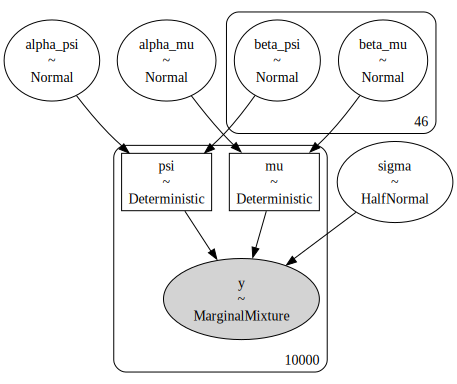

In [105]:
pm.model_to_graphviz(model)

In [106]:
with model:
    idata = pm.sample_prior_predictive()

/Users/erikdains/Programming/PythonBlogProjects/venv/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [alpha_mu, alpha_psi, beta_mu, beta_psi, sigma, y]


In [107]:
psi_samples = np.ravel(az.extract(idata.prior).psi.to_numpy())
mu_samples = np.ravel(az.extract(idata.prior).mu.to_numpy())
y_samples = np.ravel(az.extract(idata.prior_predictive).y.to_numpy())

(array([226054., 238411., 227643., 217160., 207204., 198979., 193883.,
        189139., 187128., 184156., 181715., 180568., 181149., 181719.,
        182084., 184803., 187160., 190970., 195309., 200461., 207495.,
        214018., 219992., 222755., 200045.]),
 array([4.49270730e-08, 4.00000399e-02, 8.00000349e-02, 1.20000030e-01,
        1.60000025e-01, 2.00000020e-01, 2.40000015e-01, 2.80000010e-01,
        3.20000005e-01, 3.60000000e-01, 3.99999995e-01, 4.39999990e-01,
        4.79999985e-01, 5.19999980e-01, 5.59999975e-01, 5.99999970e-01,
        6.39999965e-01, 6.79999960e-01, 7.19999955e-01, 7.59999950e-01,
        7.99999945e-01, 8.39999940e-01, 8.79999935e-01, 9.19999930e-01,
        9.59999925e-01, 9.99999920e-01]),
 <BarContainer object of 25 artists>)

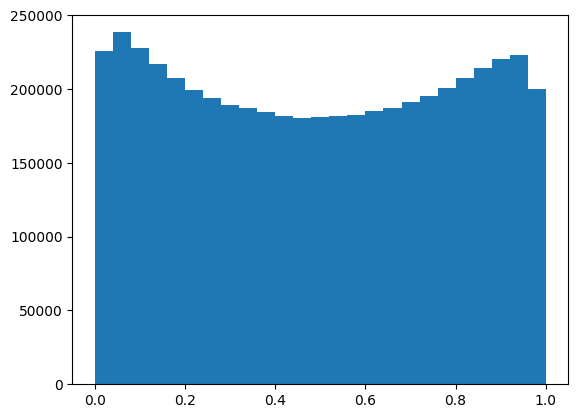

In [108]:
plt.hist(psi_samples, bins=25)

(array([1.780704e+06, 3.038679e+06, 1.635920e+05, 1.241700e+04,
        2.561000e+03, 9.250000e+02, 4.020000e+02, 2.220000e+02,
        1.580000e+02, 1.090000e+02, 7.900000e+01, 6.000000e+01,
        3.600000e+01, 2.400000e+01, 1.000000e+01, 8.000000e+00,
        7.000000e+00, 1.000000e+00, 1.000000e+00, 3.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00]),
 array([ 0.05098391,  0.89854556,  1.74610721,  2.59366885,  3.4412305 ,
         4.28879215,  5.1363538 ,  5.98391545,  6.8314771 ,  7.67903875,
         8.5266004 ,  9.37416205, 10.2217237 , 11.06928535, 11.916847  ,
        12.76440865, 13.6119703 , 14.45953195, 15.3070936 , 16.15465525,
        17.0022169 , 17.84977855, 18.6973402 , 19.54490185, 20.3924635 ,
        21.24002515]),
 <BarContainer object of 25 artists>)

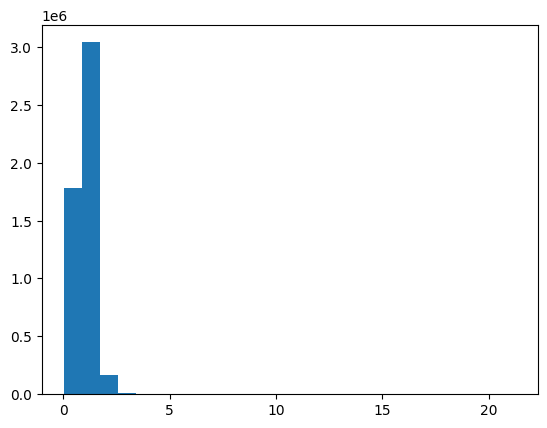

In [109]:
plt.hist(mu_samples, bins=25)

(array([4.999996e+06, 2.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([       0.        ,  7497217.85861636, 14994435.71723272,
        22491653.57584907, 29988871.43446543, 37486089.29308179,
        44983307.15169814, 52480525.0103145 , 59977742.86893086,
        67474960.72754721, 74972178.58616358]),
 <BarContainer object of 10 artists>)

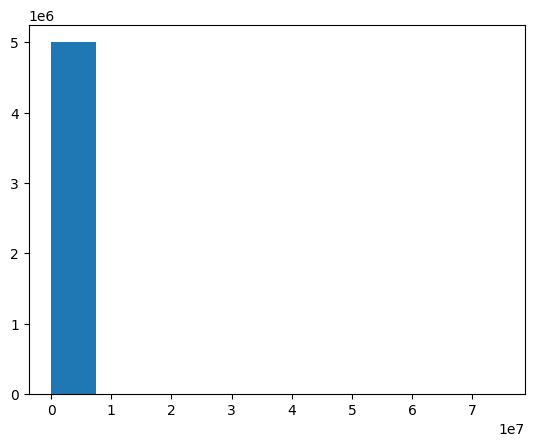

In [110]:
plt.hist(y_samples)

In [113]:
with model:
    idata = pm.sample(chains=4, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha_psi, alpha_mu, beta_psi, beta_mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 582 seconds.


<Axes: >

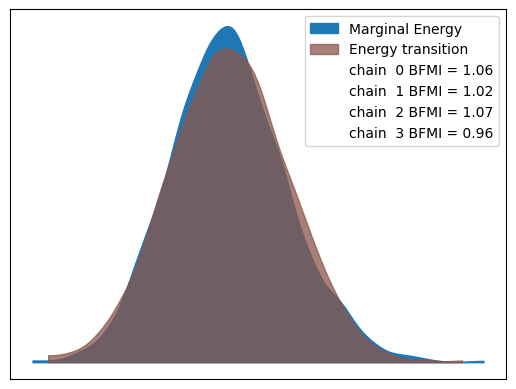

In [116]:
az.plot_energy(idata)

In [117]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))
    idata.extend(pm.compute_log_likelihood(idata))

/Users/erikdains/Programming/PythonBlogProjects/venv/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:700: UserWarning: Optimization Warning: The Op erfcinv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [y]


In [170]:
y_pp = az.extract(idata.posterior_predictive).y.to_numpy()

In [163]:
posterior = az.extract(idata.posterior)
psi_p = posterior.psi.to_numpy()
mu_p = posterior.mu.to_numpy()
sigma_p = posterior.sigma.to_numpy()

In [190]:
np.mean((y - np.mean(y_pp, axis=1))**2)

33519524130.764908

In [192]:
np.mean((y - np.mean(y))**2)

33517519835.959167

In [204]:
33519524130.764908 / 33517519835.959167

1.0000597984223043

In [ ]:
# Observation: MSE is unchanged between models, but ordering ability is higher.
# Idea: predict ranking and then predict pure premium based on ranking

In [337]:
df["prediction"] = np.mean(y_pp, axis=1)
df["decile"] = pd.qcut(df["prediction"], 10, labels=range(10)).astype(int)
# Set prediction to mean of PurePremium by decile
decile_predict = df.groupby("decile")["PurePremium"].mean()
df["decile_predict"] = decile_predict.loc[df["decile"]].values

In [338]:
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,prediction,decile,decile_predict
IDpol,,,,,,,,,,,,,,,,
3163489,1,0.98,D,6,5,21,106,B2,Diesel,634,R53,602.0,614.285714,850.707619,9,18734.754519
1187925,0,0.50,D,13,10,36,50,B12,Regular,1687,R93,0.0,0.000000,142.341648,5,70.103402
1170952,0,1.00,D,4,12,60,50,B6,Regular,1408,R52,0.0,0.000000,123.747401,4,90.954395
6091689,0,0.53,C,4,1,31,51,B12,Regular,465,R11,0.0,0.000000,49.594634,0,61.425576
2203101,0,0.14,A,6,15,41,64,B13,Regular,19,R24,0.0,0.000000,200.110413,7,229.144089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046400,0,0.08,C,7,2,41,50,B12,Diesel,128,R41,0.0,0.000000,28.604281,0,61.425576
117398,0,0.34,A,9,0,51,50,B1,Regular,31,R24,0.0,0.000000,210.738551,7,229.144089
1029673,0,0.10,B,4,7,44,65,B5,Regular,56,R53,0.0,0.000000,61.122822,1,60.902711


In [339]:
np.mean((df["PurePremium"] - df["decile_predict"])**2)

33486370749.924656